Data Processing for Flurometer (for Chlorophyll Concentration)

In [33]:
import numpy as np
from numpy import genfromtxt
import ciso8601
import time
import datetime
import json
import pandas as pd
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from sklearn.preprocessing import StandardScaler

In [34]:
fluoro_timestamp = genfromtxt('unix_dataset/fluoro.txt', dtype='str',delimiter='\t')
fluoro_data = genfromtxt('unix_dataset/fluoro.txt',delimiter='\t')
timestamp = fluoro_timestamp[:,0]
raw_fluoro = fluoro_data[:,3]
proc_fluoro = []
unix_time = []
#Calibration data according to manufacturer 
scale = 0.0073
dark_count = 45
#Extract fluoroescence count and convert to chlorophyll concentration, then convert date to unix epoch
for item in raw_fluoro:
    proc_val = scale*(item-dark_count)
    if proc_val>0:
        proc_fluoro.append(proc_val)
    else:
        proc_fluoro.append(0.00001)
for timeuwu in timestamp:
    s = timeuwu.split(',')
    ss = s[0].split('.')
    ts = ciso8601.parse_datetime(s[0])
    bruh = time.mktime(ts.timetuple())
    
    
    bruh_int = int(bruh)
    unix_time.append(bruh_int)
    #print(bruh_int)



Plot chlorophyll concentration along transect

In [35]:
#Obtain coordinate data from JSON file
# Load the JSON file
with open('unix_dataset/seapath.json', 'r') as file:
    data = json.load(file)

# Extract coordinates
coordinates = data['features'][0]['geometry']['coordinates']
time = data['features'][0]['properties']['coordTimes']
# Separate longitude and latitude
longitudes = [coord[0] for coord in coordinates]
latitudes = [coord[1] for coord in coordinates]

#Save to pandas dataframe for lookup
coord_frame = pd.DataFrame({'time':time, 'long':longitudes, 'lat':latitudes})
chloro_frame = pd.DataFrame({'time':unix_time, 'chloro':proc_fluoro})

coord_frame['time'] = pd.to_datetime(coord_frame['time'], unit='ms')
chloro_frame['time'] = pd.to_datetime(chloro_frame['time'], unit='s')

coord_filt = coord_frame[coord_frame['time'].dt.minute.isin([0,15,30,45])]
chloro_filt = chloro_frame[chloro_frame['time'].dt.minute.isin([0,15,30,45])]
chloro_second_filt = chloro_filt[chloro_filt['time'].dt.second.isin([0])]

print(coord_filt)
print(chloro_second_filt)
chloro_second_filt.to_csv('chloro_conc.csv')
#Merge coordinate and chlorophyll concentration data
merged_data = coord_filt.merge(chloro_second_filt, on='time')
print(merged_data)
#FINALLYYYYYYYYYYYYYYYYYYYYYYYYYY
merged_data['chloro'] = np.log10(merged_data['chloro'])  #for better chlorophyll processing

                     time       long       lat
14    2025-01-07 00:15:00  73.503927  4.277260
29    2025-01-07 00:30:00  73.503999  4.277357
44    2025-01-07 00:45:00  73.504180  4.277538
59    2025-01-07 01:00:00  73.504082  4.277379
74    2025-01-07 01:15:00  73.503951  4.277085
...                   ...        ...       ...
11565 2025-01-15 00:45:00  50.854759 -8.779386
11580 2025-01-15 01:00:00  50.811231 -8.799079
11595 2025-01-15 01:15:00  50.768123 -8.818561
11610 2025-01-15 01:30:00  50.724387 -8.838173
11625 2025-01-15 01:45:00  50.679691 -8.858461

[776 rows x 3 columns]
                      time   chloro
0      2025-01-08 20:00:00  0.00001
842    2025-01-08 20:15:00  0.00001
1688   2025-01-08 20:30:00  0.00001
2534   2025-01-08 20:45:00  0.00001
3380   2025-01-08 21:00:00  0.00001
...                    ...      ...
482178 2025-01-14 18:45:00  0.00001
483024 2025-01-14 19:00:00  0.00001
483869 2025-01-14 19:15:00  0.00001
484715 2025-01-14 19:30:00  0.00730
485561 2025-01-1

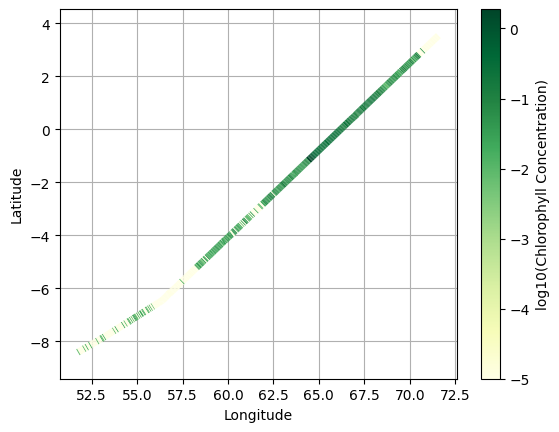

In [36]:

long = merged_data['long']
lat = merged_data['lat']
chloro = merged_data['chloro']

#Plotting of chlorophyll concentration variety along transect
def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """
    x = long
    y = lat
    z = chloro
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='YlGn',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="log10(Chlorophyll Concentration)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('chlorophyll.png')
    plt.show()

def colorline(
        x, y, z=None, cmap='hot', norm=plt.Normalize(0.0, 1.0),
        linewidth=5, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

multicolored_lines()

                   time       long       lat     temp
0   2025-01-09 04:00:00  70.274682  2.679667  20.7171
1   2025-01-09 04:00:00  70.273163  2.678648  20.7171
2   2025-01-09 04:15:00  70.228510  2.649195  20.7702
3   2025-01-09 04:30:00  70.183158  2.619343  20.8429
4   2025-01-09 04:45:00  70.137596  2.589300  20.9268
..                  ...        ...       ...      ...
525 2025-01-14 15:00:00  52.633315 -8.065936  29.0897
526 2025-01-14 15:15:00  52.584555 -8.085376  28.9928
527 2025-01-14 15:30:00  52.535338 -8.105014  29.0109
528 2025-01-14 15:45:00  52.487038 -8.124052  28.9059
529 2025-01-14 16:00:00  52.440005 -8.142798  28.7994

[530 rows x 4 columns]


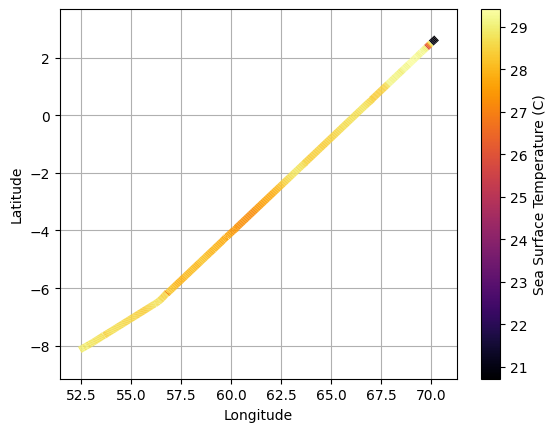

In [37]:
#Load Temperature Data
temp_data = genfromtxt("unix_dataset/temp.csv", delimiter=',')
temp_frame = pd.DataFrame({'time':temp_data[:,0], 'temp':temp_data[:,1]})
temp_frame['time'] = pd.to_datetime(temp_frame['time'], unit='ms')
temp_filt = temp_frame[temp_frame['time'].dt.minute.isin([0,15,30,45])]

#Log Operation to visualise changes better

merge_temp = coord_filt.merge(temp_filt, on='time')
print(merge_temp)

def temp_plot():
    x = merge_temp['long']
    y = merge_temp['lat']
    z = merge_temp['temp']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='inferno',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="Sea Surface Temperature (C)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('temp.png')
    plt.show()


temp_plot()


                   time       long       lat   saline
0   2025-01-09 04:00:00  70.274682  2.679667   0.0809
1   2025-01-09 04:00:00  70.273163  2.678648   0.0809
2   2025-01-09 04:15:00  70.228510  2.649195   0.0808
3   2025-01-09 04:30:00  70.183158  2.619343   0.0808
4   2025-01-09 04:45:00  70.137596  2.589300   0.0807
..                  ...        ...       ...      ...
525 2025-01-14 15:00:00  52.633315 -8.065936  34.6415
526 2025-01-14 15:15:00  52.584555 -8.085376  34.6536
527 2025-01-14 15:30:00  52.535338 -8.105014  34.6538
528 2025-01-14 15:45:00  52.487038 -8.124052  34.6253
529 2025-01-14 16:00:00  52.440005 -8.142798  34.6191

[530 rows x 4 columns]


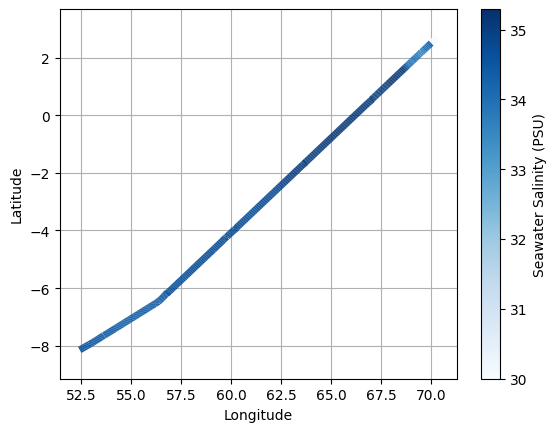

In [38]:
#Load Salinity Data
saline_data = genfromtxt("unix_dataset/salinity.csv", delimiter=',')
saline_frame = pd.DataFrame({'time':saline_data[:,0], 'saline':saline_data[:,1]})
saline_frame['time'] = pd.to_datetime(saline_frame['time'], unit='ms')
saline_filt = saline_frame[saline_frame['time'].dt.minute.isin([0,15,30,45])]

merge_saline = coord_filt.merge(saline_filt, on='time')
print(merge_saline)

def saline_plot():
    x = merge_saline['long']
    y = merge_saline['lat']
    z = merge_saline['saline']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='Blues',norm=plt.Normalize(30,z.max()))
    plt.colorbar(lc, label="Seawater Salinity (PSU)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('saline.png')
    plt.show()


saline_plot() 

                   time       long       lat     count      coeff
0   2025-01-08 20:15:00  71.539434  3.511772  0.206298   2.534158
1   2025-01-08 20:30:00  71.501183  3.486673  0.203462   2.512123
2   2025-01-08 20:45:00  71.462703  3.461385  0.204451   2.519804
3   2025-01-08 21:00:00  71.423750  3.435673  0.203662   2.513675
4   2025-01-08 21:15:00  71.385080  3.410281  0.202968   2.508294
..                  ...        ...       ...       ...        ...
556 2025-01-14 15:00:00  52.633315 -8.065936  0.700622  11.242671
557 2025-01-14 15:15:00  52.584555 -8.085376  0.700639  11.243450
558 2025-01-14 15:30:00  52.535338 -8.105014  0.700199  11.223641
559 2025-01-14 15:45:00  52.487038 -8.124052  0.699834  11.207253
560 2025-01-14 16:00:00  52.440005 -8.142798  0.698778  11.160015

[561 rows x 5 columns]


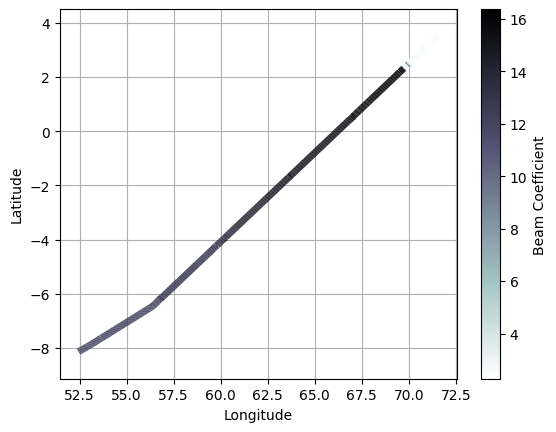

In [39]:
#Obtaining Turbidity through beam attenuation coefficient and Transmissivity
trans_data = genfromtxt('unix_dataset/trans.csv', delimiter=',')
trans_frame = pd.DataFrame({'time':trans_data[:,0], 'count':trans_data[:,1]})
trans_frame['time'] = pd.to_datetime(trans_frame['time'], unit='ms')
trans_filt = trans_frame[trans_frame['time'].dt.minute.isin([0,15,30,45])]

#Process the digital counts to obtain beam coefficient
ref_count = 15345
pathlen = 0.25


merge_trans = coord_filt.merge(trans_filt, on='time')
merge_trans['count'] /= ref_count
merge_trans['coeff'] = -1/(pathlen*np.log(merge_trans['count']))
#merge_trans['coeff'] = 1/merge_trans['coeff']
print(merge_trans)

def trans_plot():
    x = merge_trans['long']
    y = merge_trans['lat']
    z = merge_trans['coeff']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='bone_r',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="Beam Coefficient")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('trans.png')
    plt.show()


trans_plot() 


In [38]:
#Attempt at Redundancy Analysis (RDA)
test_series = merge_temp['temp']
#print(test_series)

chloro_temp = merge_temp.merge(chloro_filt, on='time')
chloro_saline = merge_saline.merge(chloro_filt, on='time')
chloro_trans = merge_trans.merge(chloro_filt, on='time')

#print(chloro_temp)
#print(chloro_saline)
#print(chloro_trans)

merge_indep = chloro_temp.merge(chloro_saline[['time', 'saline']], on='time')
merge_indep = merge_indep.merge(chloro_trans[['time', 'coeff']], on='time')
collection = pd.concat([chloro_temp['temp'], chloro_saline['saline'], chloro_trans['coeff']], axis=1)
chloro_agg = pd.concat([chloro_temp['chloro'], chloro_saline['chloro'], chloro_trans['chloro']], axis=1)
collection = collection[collection['saline'].notna()]
chloro_agg = chloro_agg[chloro_agg.iloc[:,1].notna()]
collection = np.log(collection)
chloro_agg = np.log(chloro_agg)
print(collection)
print(chloro_agg)
collection.to_csv('explanatory_matrix.csv')
chloro_agg.to_csv('response_matrix.csv')
#print(merge_indep)
#indep_vars = merge_indep[['temp', 'saline', 'coeff']]
#dep_vars = merge_indep[['chloro', 'chloro', 'chloro']]
#print(indep_vars)
#print(dep_vars)
#indep_vars.to_csv('explanatory_matrix.csv')
#dep_vars.to_csv('response_matrix.csv')
#Convert to numpy
#indep_arr = indep_vars.to_numpy()
#dep_arr = dep_vars.to_numpy()
#print(indep_arr)
#print(dep_arr)

         temp    saline     coeff
0    3.030959  3.530727 -2.792578
1    3.030959  3.528863 -2.795066
2    3.037013  3.527992 -2.733120
3    3.045032  3.530528 -2.768188
4    3.366865  3.515237 -2.776259
..        ...       ...       ...
156  3.331633  3.547336 -2.534629
157  3.329945  3.546953 -2.534473
158  3.332394  3.547192 -2.536178
159  3.331569  3.547155 -2.532158
160  3.334024  3.547181 -2.530210

[161 rows x 3 columns]
       chloro     chloro     chloro
0   -4.226734  -3.310443  -2.354932
1   -4.226734  -2.973971  -2.354932
2   -4.919881  -3.128121  -3.821269
3   -2.521986  -2.434974  -3.533587
4   -3.310443  -2.973971  -3.310443
..        ...        ...        ...
156 -3.310443  -3.821269 -11.512925
157 -3.533587 -11.512925 -11.512925
158 -4.226734  -4.919881 -11.512925
159 -2.840439  -3.128121 -11.512925
160 -3.821269  -4.919881 -11.512925

[161 rows x 3 columns]


In [14]:
from functools import reduce
#obtain common timestamps for chlorophyll data
merged_base = reduce(lambda x,y: pd.merge(x,y, on='time', how='outer'), [merge_temp[['time','temp']], merge_saline[['time','saline']], merge_trans[['time','coeff']]])
print(merged_base)

chloro_merge = merged_base

                   time     temp   saline      coeff
0   2025-01-09 04:00:00  20.7171      NaN        NaN
1   2025-01-09 04:00:00  20.7171      NaN        NaN
2   2025-01-09 04:30:00  20.8429      NaN        NaN
3   2025-01-09 05:00:00  21.0107      NaN        NaN
4   2025-01-09 05:30:00  28.9875  34.1488        NaN
..                  ...      ...      ...        ...
184 2025-01-12 23:30:00      NaN      NaN  12.495582
185 2025-01-13 00:00:00      NaN      NaN  12.594079
186 2025-01-13 00:30:00      NaN      NaN  12.577055
187 2025-01-13 01:00:00      NaN      NaN  12.614394
188 2025-01-13 01:30:00      NaN      NaN  12.585393

[189 rows x 4 columns]


In [12]:
#screw this, using R on master's computer instead
def perform_rda(X, Y):
    # Standardize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_std = scaler_x.fit_transform(X)
    Y_std = scaler_y.fit_transform(Y)
    
    # Step 1: Multiple Linear Regression
    # Calculate Y_fitted using the formula Y_fit = X(X'X)^(-1)X'Y
    X_transpose = np.transpose(X_std)
    X_square = np.linalg.inv(X_transpose.dot(X_std))
    Y_fitted = X_std.dot(X_square.dot(X_transpose.dot(Y_std)))
    
    # Step 2: PCA on fitted values
    # Calculate covariance matrix
    covariance_matrix = np.cov(Y_fitted.T)
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate canonical axes (scores)
    canonical_axes = Y_fitted.dot(eigenvectors)
    
    return canonical_axes, eigenvalues, eigenvectors

canonical_axes, eigenvalues, eigenvectors = perform_rda(indep_arr, dep_arr)
print(eigenvectors)

[[ 0.57735027  0.         -0.81649658]
 [ 0.57735027 -0.70710678  0.40824829]
 [ 0.57735027  0.70710678  0.40824829]]
